In [83]:
!%pip install adjustText

zsh:fg:1: no job control in this shell.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

from tqdm import tqdm
import math

pd.set_option('display.max_columns', 90)
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

In [85]:
movies = pd.read_csv('../data/imdb-cleaned.csv')

# Data Preparation

In [86]:
movies['total_votes'] = movies.loc[:, 'rating_1':'rating_10'].sum(axis='columns')

We made a variable `total_votes` with the total number of user votes on each movie.

In [87]:
def calc_unweighted_rating(row):
    return sum([i * row[f'rating_{i}'] for i in range(1, 11)]) / row['total_votes']

movies['unweighted_rating'] = movies.apply(calc_unweighted_rating, axis='columns')

In [88]:
def calc_polarization(row):
    total_score = 0
    for rating_1 in range(1, 11):
        for rating_2 in range(rating_1 + 1, 11):
            total_score += row[f'rating_{rating_1}'] / row['total_votes'] * row[f'rating_{rating_2}'] / row['total_votes'] * (rating_2 - rating_1)

    return total_score / 2.25

In [89]:
movies['polarization_score'] = movies.apply(calc_polarization, axis='columns')

We made a variable polarization_score with the polarization score for each movie's ratings calculated using a version of Esteban and Ray's algorithm [Esteban and Ray, 1993]. The algorithm is based on the premise that polarization in a distribution is equivalent to the sum of what they call the "effective antagonisms" in that distribution. Each pair of values—the 1s and the 10s, the 1s and the 9s, and so on—have an effective antagonism, which is a function of the difference between the two values and the number of instances of each. To find the effective antagonism between two values, we multiply the proportions of scores matching those two values in the overall distribution by each other, and then multiply that by the difference between the two values. This yields a score from 0 (not polarized at all—all ratings for the film are the same) to 2.25 (extremely polarized—exactly 50% 1s and 50% 10s). We then divide by 2.25 to obtain a score between 0 and 1, in order to produce a more intuitive number for polarization.

In [90]:
def calc_country_rating(country_idx, row):
    total_rating = 0
    total_votes = 0
    for rating in range(1, 11):
        total_rating += rating * row[f'country_{country_idx}_rating_{rating}']
        total_votes += row[f'country_{country_idx}_rating_{rating}']
    return total_rating / total_votes

In [91]:
for i in range(5):
    movies[f'country_{i}_rating'] = movies.apply(lambda row: calc_country_rating(i, row), axis='columns')

We made variables `country_{0...4}_rating` with the average rating for each of the top five countries with the most votes for each movie.

In [92]:
def calc_ptp(row):
    ptp = np.ptp(row.loc['country_0_rating':'country_4_rating'])

    max_country_idx = np.argmax(row.loc['country_0_rating':'country_4_rating'])
    min_country_idx = np.argmin(row.loc['country_0_rating':'country_4_rating'])
    max_country = row[f'country_{max_country_idx}']
    min_country = row[f'country_{min_country_idx}']

    return pd.Series([ptp, max_country, min_country])

In [93]:
movies[['country_ptp', 'max_country_ptp', 'min_country_ptp']] = movies.apply(calc_ptp, axis='columns')

We made a variable `country_ptp` with the difference between the highest and lowest average ratings between the top five countries with the most votes for each movie. The variables `max_country_ptp` and `min_country_ptp` record the country codes of the two countries with the highest and lowest average ratings for each movie, respectively.

In [94]:
movies['rating_diff'] = movies['weighted_rating'] - movies['unweighted_rating']

We made a variable `rating_diff` with the difference between the weighted (by IMDb) rating and the unweighted rating for each movie.

In [95]:
movies['pct_polarized_votes'] = (movies['rating_1'] + movies['rating_10']) / movies['total_votes']

We made a variable `pct_polarized_votes` with the percentage of votes that are polarized (i.e., 1 or 10).

In [96]:
movies['genres'] = movies['genres'].str.split(',')
movies['keywords'] = movies['keywords'].str.split(',')

We split the `genres` and `keywords` columns into lists.

In [97]:
movies['keywords'] = movies['keywords'].apply(lambda keywords: keywords if isinstance(keywords, list) else [])

Replace empty `keywords` values with empty lists.

In [98]:
movies[movies['keywords'].isna()]

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes


# EDA

In [99]:
movies.sort_values('polarization_score', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
2955,tt4776998,The Promise,"[Period Drama, Action, Adventure, Drama, War]",6.1,2017,"[love triangle, armenian genocide, belly dance...",71664,789,469,779,1813,4252,5880,4504,3097,86292,US,1835,94,82,184,404,997,1346,1148,920,21033,TR,18262,364,124,91,90,103,94,42,26,503,RU,266,8,10,17,43,78,90,52,39,8779,GB,710,22,20,61,131,361,459,334,168,3350,AM,5,2,0,3,3,20,33,25,52,4496,179539,6.017227,0.979287,8.851514,1.373268,9.619484,7.972934,9.919164,8.545896,AM,TR,0.082773,0.879787
4363,tt7668842,Enes Batur: Imagination or Reality?,[Comedy],2.0,2018,[college],21574,747,529,348,474,375,434,478,501,30874,TR,14614,565,399,264,320,242,282,247,231,14040,US,370,28,19,8,12,12,7,3,5,106,AZ,108,7,7,6,7,5,2,6,5,270,GB,184,10,6,2,3,5,4,4,2,46,MY,1,0,0,1,0,0,0,0,0,176,56334,6.226755,0.972132,5.367197,3.201754,7.184397,3.056391,9.915730,6.859339,MY,GB,-4.226755,0.931019
4280,tt6277462,Brahmastra Part One: Shiva,"[Action Epic, Adventure Epic, Dark Fantasy, Su...",5.6,2022,"[fantasy superhero, non comic book superhero, ...",42084,3976,2368,2513,3642,4830,6707,6529,6943,34240,IN,34401,2968,1618,1581,2164,2858,4331,4701,5649,28721,US,3175,419,301,350,560,741,944,751,522,1804,GB,1607,193,132,173,262,389,470,389,233,947,BD,448,85,67,110,180,239,250,179,125,666,CA,503,66,39,40,58,69,79,72,70,359,113832,5.433007,0.955283,5.455086,5.112993,5.149948,6.198382,5.140221,1.085390,BD,US,0.166993,0.670497
4019,tt26932223,Bhool Bhulaiyaa 3,"[Supernatural Horror, Comedy, Fantasy, Horror]",4.6,2024,"[female ghost, supernatural horror, horror com...",22685,5210,4957,3750,1610,1613,1203,3431,9249,23650,IN,21366,4830,4547,3243,910,939,749,3149,9048,22957,US,385,116,128,168,227,226,148,97,71,162,GB,171,63,66,78,116,137,77,39,21,102,BD,164,44,60,71,114,88,69,49,28,96,PK,88,28,30,33,43,40,30,20,10,77,77358,5.640192,0.949742,5.704926,4.765625,4.906897,4.982120,5.140351,0.939301,IN,US,-1.040192,0.598968
4332,tt12915716,Adipurush,"[Action Epic, Epic, Action, Drama]",2.7,2023,"[ramayan, jai shree ram, ram siya ram, based o...",51245,3099,1585,1061,1088,1197,4074,19146,20884,32019,IN,40686,2198,1057,661,710,943,3770,18744,20506,30314,US,3480,301,199,142,157,89,158,129,166,593,GB,1791,176,95,72,58,37,49,46,111,260,BD,1115,118,61,48,40,23,11,6,6,105,NP,723,31,17,5,5,2,3,5,2,52,135398,5.678784,0.942380,6.055248,2.978943,2.797032,2.148076,1.765680,4.289567,IN,NP,-2.978784,0.614957
4232,tt10028196,Laal Singh Chaddha,"[Epic, Comedy, Drama, Romance]",5.6,2022,"[indian remake of american film, foreign langu...",97793,4265,1440,975,1514,2486,3558,7466,14411,45530,IN,84286,3315,982,499,653,958,1485,5371,12765,35375,US,5678,406,161,151,230,392,573,615,

Here are the top ten movies sorted by `polarization_score` (i.e. the movies with the most polarized rating distributions).

In [100]:
movies.sort_values('rating_diff', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
4336,tt7825208,Marighella,"[Docudrama, Political Thriller, Action, Drama,...",7.1,2021,"[dictatorship, military dictatorship, fascism,...",38399,697,186,103,180,386,799,972,799,13956,BR,35665,635,149,67,116,272,609,777,666,12348,US,1258,23,7,19,16,28,49,58,38,444,PT,303,7,3,6,6,25,37,38,23,195,GB,221,3,3,2,6,6,9,13,11,162,CA,178,5,3,0,1,3,8,7,11,86,56477,3.613843,0.822324,3.504892,3.730928,5.054432,5.036697,4.274834,1.549540,PT,BR,3.486157,0.927015
48,tt5971474,The Little Mermaid,"[Fairy Tale, Feel-Good Romance, Sea Adventure,...",7.2,2023,"[fairy tale, little mermaid, magic spell, disn...",46991,8893,6310,6728,11659,19742,24675,16253,8055,21421,US,14100,2760,1960,1853,2966,5008,7315,5991,3549,10457,GB,2708,650,481,616,1115,2048,2649,1703,764,1299,CA,1468,290,218,237,400,653,903,673,349,725,BR,1246,225,176,212,415,738,813,651,283,828,DE,1525,324,254,285,496,757,867,388,178,256,170727,5.135802,0.814306,5.601137,5.544859,5.352265,5.602470,4.583865,1.018605,BR,DE,2.064198,0.400710
1803,tt1289401,Ghostbusters,"[Slapstick, Supernatural Fantasy, Action, Come...",6.8,2016,"[reboot, vomiting, woman slaps a woman, femini...",44021,13140,14684,20848,33167,41323,34151,19329,8384,23741,US,12674,3671,3835,5165,8180,10922,10815,7109,3262,7735,GB,4757,1595,1919,2588,4042,5453,4810,2607,921,1858,CA,1585,601,604,779,1288,1643,1494,915,389,828,DE,1595,590,782,1062,1582,1733,1260,521,177,320,SE,1414,447,480,739,1232,1304,886,451,174,1154,252788,5.214144,0.705143,5.423318,5.184255,5.290539,4.724382,5.265548,0.698936,US,DE,1.585856,0.268059
3083,tt10083340,Gangubai Kathiawadi,"[True Crime, Biography, Crime, Drama]",7.8,2022,"[underworld, based on real people, life, teena...",16475,1160,764,859,1528,3090,6609,7522,4346,21669,IN,12217,777,466,487,780,1391,2749,3330,2158,16904,US,1852,166,114,128,253,521,1109,1244,670,2129,GB,1144,86,61,58,128,289,692,781,403,688,BD,154,16,22,36,61,150,335,309,158,313,PK,51,7,12,15,37,80,161,187,104,182,64022,6.450064,0.877105,6.391527,6.408991,5.936259,7.059202,7.422249,1.485990,PK,GB,1.349936,0.595795
4232,tt10028196,Laal Singh Chaddha,"[Epic, Comedy, Drama, Romance]",5.6,2022,"[indian remake of american film, foreign langu...",97793,4265,1440,975,1514,2486,3558,7466,14411,45530,IN,84286,3315,982,499,653,958,1485,5371,12765,35375,US,5678,406,161,151,230,392,573,615,469,2527,GB,3085,192,83,74,146,221,317,361,273,1336,CA,845,49,14,21,25,56,88,98,98,1067,BD,567,45,42,52,92,132,173,182,142,902,179438,4.495491,0.936800,4.302789,4.418943,4.433968,6.133842,6.529841,2.227052,BD,IN,1.104509,0.798733
127,tt20221436,Emilia Pérez,"[Pop Musical, Comedy, Crime, Drama, Musical, T...",5.4,2024,"[

Here are the top ten movies sorted by `rating_diff` (i.e. the movies to which IMDb made the largest positive rating adjustments).

In [101]:
movies.sort_values('pct_polarized_votes', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
4178,tt5988370,Reis,"[Biography, Drama]",1.0,2017,"[turk, prime minister, president]",59761,237,63,42,77,47,52,61,115,13847,TR,37481,148,41,24,38,24,29,32,76,7993,US,2075,15,4,3,3,1,3,2,0,141,DE,749,3,0,0,2,3,1,3,1,291,GB,975,5,1,1,1,1,1,0,4,62,NL,268,1,0,0,0,0,0,0,0,169,74302,2.713467,0.616528,2.602166,1.600801,3.545109,1.585157,4.474886,2.889729,NL,GB,-1.713467,0.990660
4351,tt7886848,Sadak 2,"[Action, Drama]",1.2,2020,"[running, sequel]",92017,570,345,265,319,273,263,244,243,2433,IN,69911,316,172,132,162,153,152,141,151,1581,US,9572,104,77,41,60,43,36,37,27,261,GB,5617,46,35,36,28,27,23,15,19,153,BD,1308,17,13,11,15,10,9,9,5,68,CA,1039,5,5,2,6,2,5,5,1,22,96972,1.328167,0.140273,1.271782,1.377851,1.373896,1.651877,1.298535,0.380095,BD,IN,-0.128167,0.973992
4325,tt10811166,The Kashmir Files,"[Political Drama, Tragedy, Drama]",8.5,2022,"[kashmiri pandit, genocide, brutality, massacr...",32041,1560,914,750,1183,1474,2500,4299,9269,522118,IN,22461,1054,597,477,768,894,1616,2901,6871,442716,US,2726,187,134,101,177,240,376,628,1126,35858,GB,1651,95,47,55,65,125,197,342,656,21444,BD,1495,50,30,18,40,36,63,83,80,2865,CA,400,20,13,13,15,19,30,50,80,3990,576108,9.394341,0.250561,9.495042,9.207542,9.228674,6.858824,9.060475,2.636219,IN,BD,-0.894341,0.961901
0,tt6208148,Snow White,"[Fairy Tale, Feel-Good Romance, Adventure, Fam...",1.6,2025,"[narcissism, dystopia, hag, tyrant, female vil...",298112,5960,2014,1679,2142,2458,2620,2210,1279,9293,US,78189,2040,622,480,649,801,1037,934,519,3345,GB,20221,372,173,181,244,273,327,248,136,778,BR,10915,238,100,77,85,77,63,61,40,329,CA,10113,181,71,50,57,75,99,110,55,357,IN,10637,98,32,17,23,23,21,16,26,164,327767,1.491026,0.204876,1.658369,1.670501,1.457238,1.545577,1.211812,0.458689,GB,IN,0.108974,0.937877
4354,tt10554232,Dara of Jasenovac,"[Drama, War]",8.1,2021,[genocide of serbs in the independent state of...,3820,261,176,201,348,560,944,1222,1533,73044,RS,190,54,53,72,97,153,220,347,774,46349,BA,813,46,20,13,22,23,21,32,69,9281,US,205,13,16,15,48,58,103,125,144,2952,ME,52,3,3,2,6,7,13,18,37,3100,HR,1760,74,32,31,39,26,31,24,12,449,82109,9.394768,0.249225,9.872281,9.197195,9.095950,9.785560,3.020985,6.851296,RS,HR,-1.294768,0.936121
4363,tt7668842,Enes Batur: Imagination or Reality?,[Comedy],2.0,2018,[college],21574,747,529,348,474,375,434,478,501,30874,TR,14614,565,399,264,320,242,282,247,231,14040,US,370,28,19,8,12,12,7,3,5,106,AZ,108,7,7,6,7,5,2,6,5,270,GB,184,10,6,2,3,5,4,4,2,46,MY,1,0,0,1,0,0,0,0,0,176,56334,6.226755,0.972132,5.367197,3.201754,7.184397,3.056391,9.915730,6.859339,MY,GB,-4.226755,0.931019
4336,tt7825208,Marighella,"[Docudrama, Political T

Here are the top ten movies sorted by `pct_polarized_votes` (i.e. the movies with the largest percentage of polarized votes).

In [102]:
movies[['weighted_rating', 'unweighted_rating', 'rating_diff', 'polarization_score', 'pct_polarized_votes']].describe()

,weighted_rating,unweighted_rating,rating_diff,polarization_score,pct_polarized_votes
count,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000
mean,6.820779,6.953024,-0.132245,0.417266,0.130133
std,0.908974,0.869417,0.218184,0.076494,0.097673
min,1.000000,1.328167,-4.226755,0.140273,0.036992
25%,6.300000,6.429427,-0.189671,0.365988,0.078170
50%,6.900000,7.018278,-0.119348,0.405925,0.103744
75%,7.500000,7.581858,-0.050957,0.451285,0.144344
max,9.300000,9.394768,3.486157,0.979287,0.990660


Here are the summary statistics for the numeric variables in the dataset.

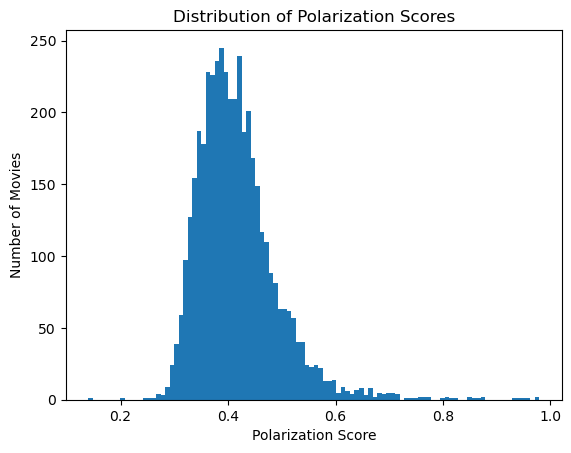

In [103]:
plt.hist(movies['polarization_score'], bins=100)
plt.xlabel('Polarization Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Polarization Scores')
plt.show()

The distribution of polarization scores is somewhat right-skewed, centered approximately around 0.4.

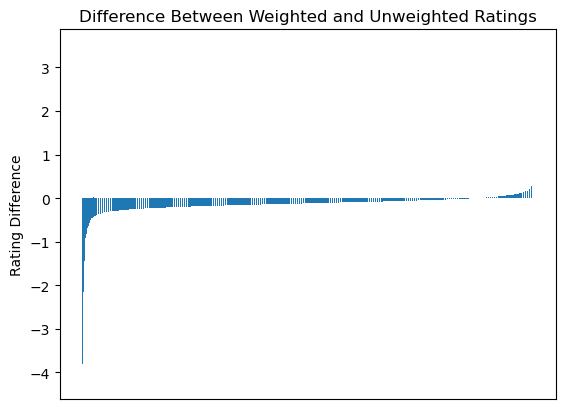

In [104]:
df_to_plot = movies.sort_values('rating_diff', ascending=True)

plt.bar(df_to_plot['title'], df_to_plot['rating_diff'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Rating Difference')
plt.title('Difference Between Weighted and Unweighted Ratings')
plt.show()

The distribution of rating difference shows that IMDb's weighting algorithm tends to yield lower scores than the unweighted ratings, with some exceptions. Most films' ratings are adjusted by tenths of a point or less, although some, visible on the ends of the distribution, have their ratings drastically altered by the algorithm.

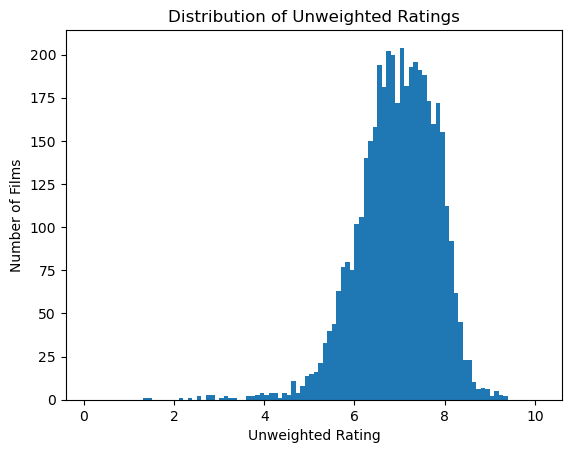

In [105]:
#define bins at each hundredth between 0 and 10
my_bins = [0.1]
for i in range(100):
    my_bins.append(my_bins[i] + 0.1)

plt.hist(movies['unweighted_rating'], bins=my_bins)
plt.xlabel('Unweighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Unweighted Ratings')
plt.show()

The distribution of unweighted ratings is left-skewed and centered approximately around 7.

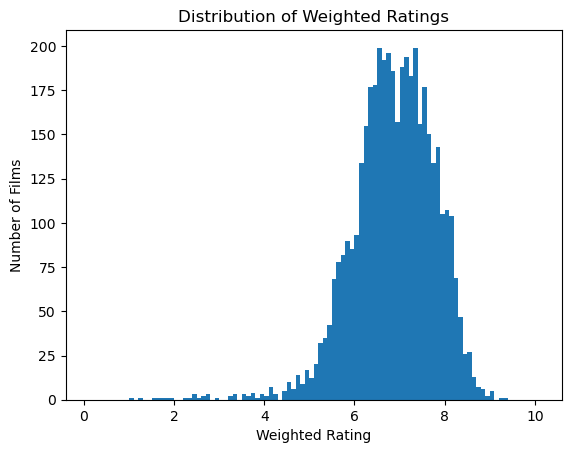

In [106]:
plt.hist(movies['weighted_rating'], bins=my_bins)
plt.xlabel('Weighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Weighted Ratings')
plt.show()

The distribution of weighted ratings looks very similar—it is also left-skewed and has a center of close to 7. However, on closer examination, it is clear that this distribution has a slightly lower center as a result of the algorithm's tendency to slightly lower ratings.

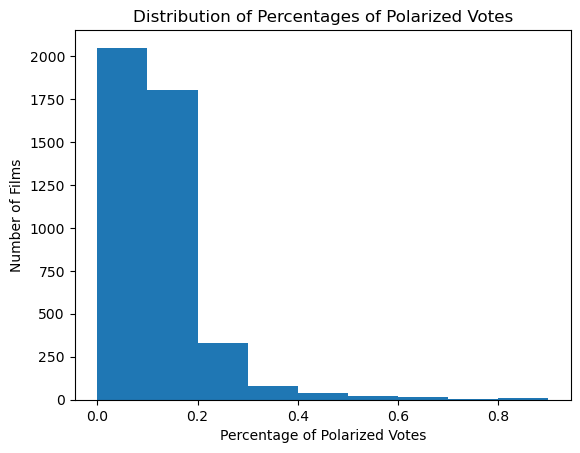

In [107]:
plt.hist(movies['pct_polarized_votes'], bins=np.arange(0.0, 1.0, 0.1))
plt.xlabel('Percentage of Polarized Votes')
plt.ylabel('Number of Films')
plt.title('Distribution of Percentages of Polarized Votes')
plt.show()

The distribution of the percentage polarized votes is highly right-skewed, with almost all movies having fewer than 20% polarized votes.

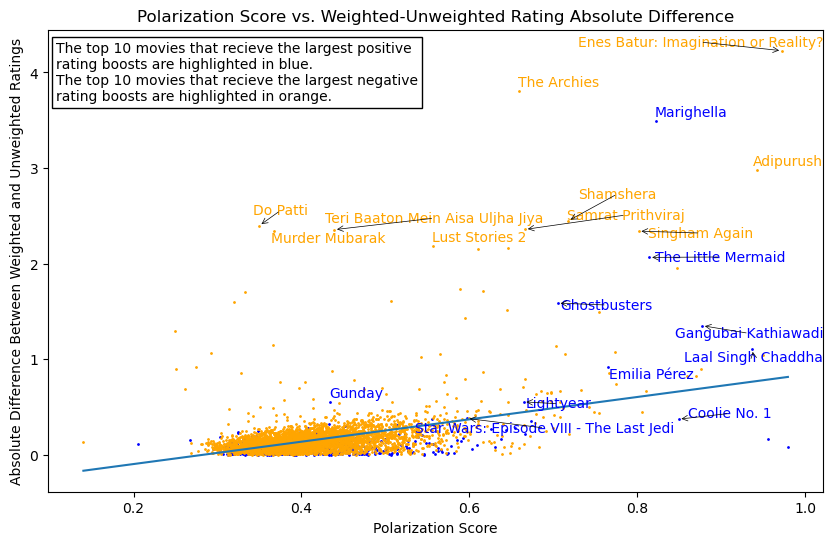

In [108]:
df_to_plot = movies.sort_values('rating_diff', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(movies[movies['rating_diff'] > 0]['polarization_score'], movies[movies['rating_diff'] > 0]['rating_diff'].abs(), s=1, color='blue')
ax.scatter(movies[movies['rating_diff'] <= 0]['polarization_score'], movies[movies['rating_diff'] <= 0]['rating_diff'].abs(), s=1, color='orange')

texts = []
for i, movie in enumerate(df_to_plot.tail(10).itertuples()):
    texts.append(ax.text(movie.polarization_score, abs(movie.rating_diff), movie.title, color='blue'))

for i, movie in enumerate(df_to_plot.head(10).itertuples()):
    texts.append(ax.text(movie.polarization_score, abs(movie.rating_diff), movie.title, color='orange'))


adjust_text(texts, autoalign='xy', 
            expand_points=(1.2, 1.2), 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

text_str = 'The top 10 movies that recieve the largest positive\nrating boosts are highlighted in blue.\nThe top 10 movies that recieve the largest negative\nrating boosts are highlighted in orange.'
props = dict(boxstyle='square', facecolor='white')
ax.text(0.01, 0.975, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)

ax.plot(np.unique(movies['polarization_score']), np.poly1d(np.polyfit(movies['polarization_score'], movies['rating_diff'].abs(), 1))(np.unique(movies['polarization_score'])))
plt.ylabel('Absolute Difference Between Weighted and Unweighted Ratings')
plt.xlabel('Polarization Score')
plt.title('Polarization Score vs. Weighted-Unweighted Rating Absolute Difference')
plt.show()

In general, it seems as though films with higher polarization scores are more likely to have their ratings heavily adjusted by IMDb's weighting algorithm (positive correlation between absolute rating difference and polarization score).

In [109]:
movies['polarization_score'].corr(movies['rating_diff'].abs())

0.4431683113650262

There is a low positive correlation between `polarization_score` and absolute `rating_diff`.

## IMDb's Weighting Algorithm

In [110]:
ovr_avg_rating_diff = movies['rating_diff'].mean()

What kinds of movies does IMDb's weighting algorithm boost or de-boost?

Here, we calculate an `avg_rating_boost`, broken down by genre and keyword. The rating boost is calculated by comparing the how much the rating for a movie tagged with a specific genre or keyword is increased/decreased by IMDb's algorithm, on average, compared to a how much the alogrithm increases/decreases movie ratings overall on average (`ovr_avg_rating_diff`). A positive value indicates that the algorithm tends to boost ratings for that genre or keyword, while a negative value indicates that the algorithm tends to de-boost ratings for that genre or keyword.

In [111]:
genres_weighting_data = []

all_genres = movies['genres'].explode()
genre_counts = all_genres.value_counts()
top_genres = genre_counts[genre_counts > 100].index.tolist()

for genre in top_genres:
    genre_movies = movies[movies['genres'].apply(lambda x: genre in x)]
    cum_rating_diff = genre_movies['rating_diff'].sum()
    num_movies = len(genre_movies)
    avg_rating_diff = cum_rating_diff / num_movies
    genres_weighting_data.append({
        'genre': genre,
        'avg_rating_boost': avg_rating_diff - ovr_avg_rating_diff,
        'num_movies': num_movies
    })

genres_weighting_df = pd.DataFrame(genres_weighting_data)

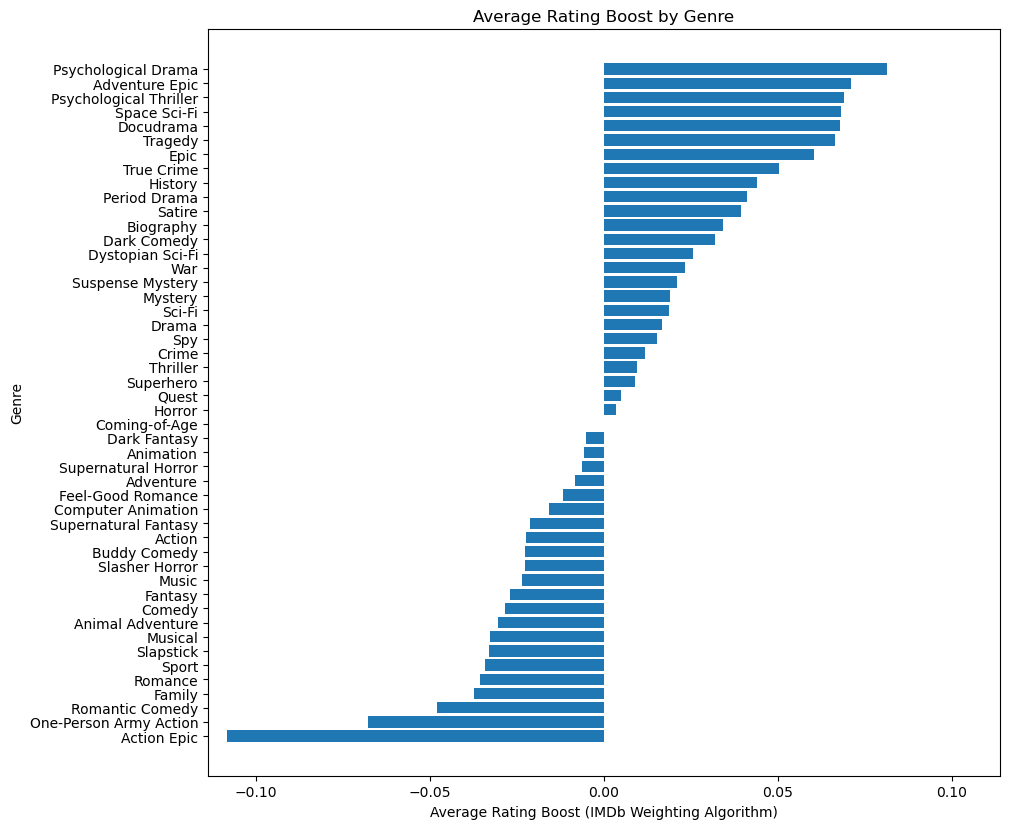

In [112]:
genres_weighting_df = genres_weighting_df.sort_values('avg_rating_boost', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(genres_weighting_df['genre'], genres_weighting_df['avg_rating_boost'])
max_abs_value = genres_weighting_df['avg_rating_boost'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Genre')
plt.xlabel('Average Rating Boost (IMDb Weighting Algorithm)')
plt.title('Average Rating Boost by Genre')
plt.show()

In [113]:
genres_weighting_df.sort_values('avg_rating_boost', ascending=False).head(50)

,genre,avg_rating_boost,num_movies
18,Psychological Drama,0.081236,252
46,Adventure Epic,0.071096,105
19,Psychological Thriller,0.068979,243
41,Space Sci-Fi,0.068009,110
23,Docudrama,0.067817,191
15,Tragedy,0.066328,284
29,Epic,0.060269,151
44,True Crime,0.050216,108
26,History,0.044036,176
13,Period Drama,0.041131,365


Genres associated with more politically controversial subject material (e.g. "War", "Period Drama", "Docudrama", "History", "Biography", "Satire") as well as genres more likely to have violent or non-culturally normative themes (e.g. "Psychological Drama", "Psychological Thriller", "True Crime", "Dark Comedy", "Dystopian Sci-fi") are among those boosted most by IMDb's weighting algorithm. Genres associated with more mainstream, family-friendly, or culturally normative themes (e.g. "Family", "Romance", "Musical", "Romantic Drama", "Slapstick", "Sport", "Action Epic", "Animal Adventure", "Comedy", "Fantasy", "") are among those de-boosted most by the algorithm. This suggests that the algorithm is more likely to boost ratings for films with more controversial subject matter, while de-boosting ratings for films with more mainstream or family-friendly themes. This is consistent with the idea that IMDb's weighting algorithm is designed to reduce the influence of unrepresentative user ratings on the overall rating, which may be more likely to be positive for films with more mainstream or family-friendly themes and more negative for films with more controversial subject matter.

In [114]:
keywords_weighting_data = []

all_keywords = movies['keywords'].explode()
keyword_counts = all_keywords.value_counts()
top_keywords = keyword_counts[keyword_counts > 30].index.tolist()

for keyword in top_keywords:
    keyword_movies = movies[movies['keywords'].apply(lambda x: keyword in x)]
    cum_rating_diff = keyword_movies['rating_diff'].sum()
    num_movies = len(keyword_movies)
    avg_rating_diff = cum_rating_diff / num_movies
    keywords_weighting_data.append({
        'keyword': keyword,
        'avg_rating_boost': avg_rating_diff - ovr_avg_rating_diff,
        'num_movies': num_movies
    })

keywords_weighting_df = pd.DataFrame(keywords_weighting_data)

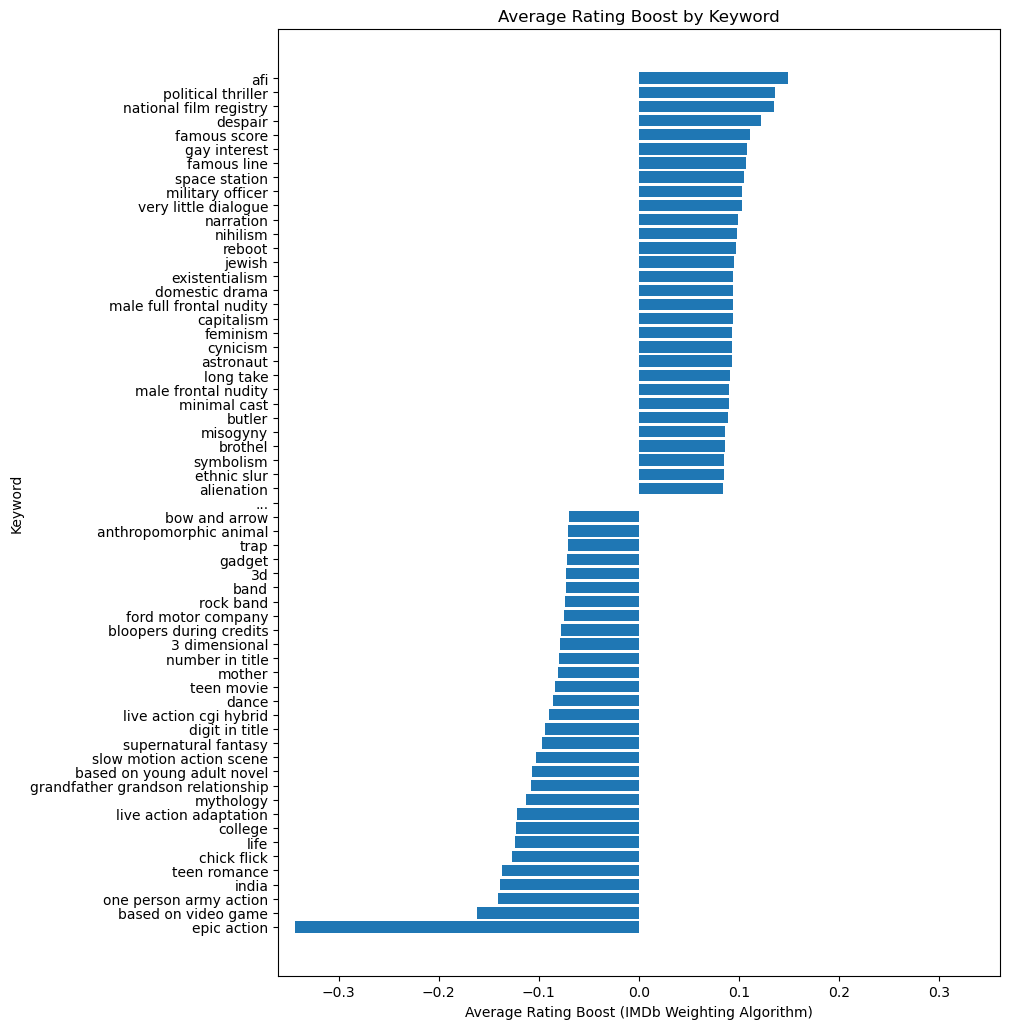

In [115]:
keywords_weighting_df = keywords_weighting_df.sort_values('avg_rating_boost', ascending=True)

df_to_plot = pd.concat((
    keywords_weighting_df.head(30),
    pd.DataFrame([{'keyword': '...', 'avg_rating_boost': 0}]),
    keywords_weighting_df.tail(30)
))

plt.figure(figsize=(10, 10))
plt.barh(df_to_plot['keyword'], df_to_plot['avg_rating_boost'])
max_abs_value = df_to_plot['avg_rating_boost'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Keyword')
plt.xlabel('Average Rating Boost (IMDb Weighting Algorithm)')
plt.title('Average Rating Boost by Keyword')
plt.show()

In [116]:
keywords_weighting_df.sort_values('avg_rating_boost', ascending=False).head(30)

,keyword,avg_rating_boost,num_movies
1639,afi,0.149369,41
1410,political thriller,0.136259,47
157,national film registry,0.135575,226
1258,despair,0.121780,52
374,famous score,0.111216,132
1694,gay interest,0.108085,40
674,famous line,0.106980,88
1648,space station,0.105019,41
1271,military officer,0.103102,51
1654,very little dialogue,0.102892,41


Keywords associated with more high-brow movies (e.g. "afi", "national film registry", "very little dialogue", "symbolism") as well as will controversial subject material (e.g. "political thriller", "gay interest", "jewish", "capitalism", "feminism", "military officer", "male frontal nudity", "misogyny", "brothel", "ethnic slur", "alienation") are among those boosted most by IMDb's weighting algorithm.

In [117]:
keywords_weighting_df.sort_values('avg_rating_boost', ascending=True).head(30)

,keyword,avg_rating_boost,num_movies
1273,epic action,-0.343502,51
1906,based on video game,-0.161889,35
920,one person army action,-0.140376,67
1376,india,-0.138876,48
1277,teen romance,-0.136504,51
1760,chick flick,-0.126897,38
1896,life,-0.123555,35
610,college,-0.123087,96
2028,live action adaptation,-0.121797,33
1771,mythology,-0.112385,38


Keywords associated with more mainstream movies ("epic action", "based on video game", "teen romance", "chick flick", "college", "live action adaptation", "based on young adult novel", "teen movie") are among those boosted least by IMDb's weighting algorithm.

## Effect of Weighting Algorithms on a Hypothetical Recommendation Algorithm

In [118]:
def naive(movie, movies_not_me, rating_column):
    movie_keywords = set(movie.keywords)

    matching_keyword_score = movies_not_me['keywords'].apply(lambda x: len(movie_keywords.intersection(set(x)))) / len(movie_keywords) * 10
    rating_score = movies_not_me[rating_column]

    recommendation_score = matching_keyword_score * rating_score

    return recommendation_score


def recommendation_algo(movies, rating_column, algo=naive):
    recommendation_data = pd.DataFrame({
        'title': movies['title'],
        'num_recommendations': 0,
    })

    for _, movie in tqdm(
        enumerate(movies.itertuples()),
        desc=f'recommending movies using "{rating_column}" ...',
        total=len(movies)
    ):
        movies_not_me = movies[movies.index != movie.Index]

        recommendation_score = naive(movie, movies_not_me, rating_column)
        recommendation_score.sort_values(ascending=False, inplace=True)
        top_movies = movies.loc[recommendation_score.index]

        recommendation_data.loc[recommendation_data.index.isin(top_movies.head(10).index), 'num_recommendations'] += 1

    return recommendation_data

In [119]:
weighted_recommendation_data = recommendation_algo(movies, 'weighted_rating')
unweighted_recommendation_data = recommendation_algo(movies, 'unweighted_rating')

recommending movies using "weighted_rating" ...: 100%|██████████| 4365/4365 [02:19<00:00, 31.36it/s]
recommending movies using "unweighted_rating" ...: 100%|██████████| 4365/4365 [02:31<00:00, 28.78it/s]


In [120]:
diff_recommendation_data = weighted_recommendation_data.copy()
diff_recommendation_data['num_recommendations'] -= unweighted_recommendation_data['num_recommendations']
diff_recommendation_data.rename(columns={'num_recommendations': 'num_recommendations_diff'}, inplace=True)
diff_recommendation_data['num_recommendations_diff_pct'] = diff_recommendation_data['num_recommendations_diff'] / unweighted_recommendation_data.loc[diff_recommendation_data.index]['num_recommendations']

In [121]:
diff_recommendation_data[diff_recommendation_data['num_recommendations_diff_pct'] != math.inf].sort_values('num_recommendations_diff_pct', ascending=False).head(25)

,title,num_recommendations_diff,num_recommendations_diff_pct
48,The Little Mermaid,21,7.0
2377,Lightyear,5,2.5
4126,Sherlock Jr.,4,2.0
2165,Sorry to Bother You,2,2.0
3769,The River Wild,2,2.0
1601,Still Alice,2,2.0
3169,Hotel Mumbai,2,2.0
651,The Killing of a Sacred Deer,2,2.0
3797,The General,3,1.5
3435,Blood Red Sky,3,1.5


In [122]:
diff_recommendation_data.sort_values('num_recommendations_diff', ascending=False).head(25)

,title,num_recommendations_diff,num_recommendations_diff_pct
440,Die Hard,26,0.276596
38,The Godfather,26,0.189781
1,Anora,23,0.338235
48,The Little Mermaid,21,7.000000
228,City of God,17,0.177083
85,Se7en,16,0.075117
173,Oldboy,16,0.087432
285,Sin City,16,0.188235
1516,Metropolis,15,0.468750
193,The Lord of the Rings: The Return of the King,14,0.254545


In [123]:
diff_recommendation_data.sort_values('num_recommendations_diff', ascending=True).head(25)

,title,num_recommendations_diff,num_recommendations_diff_pct
37,I'm Still Here,-40,-0.512821
4354,Dara of Jasenovac,-29,-0.707317
3809,Jawan,-22,-0.440000
455,The Gray Man,-16,-0.161616
3289,The Host,-16,-0.421053
2507,Great Expectations,-15,-0.172414
2922,DC League of Super-Pets,-14,-0.437500
517,Venom,-13,-0.151163
4265,Sholay,-12,-0.142857
47,Den of Thieves,-12,-0.072289


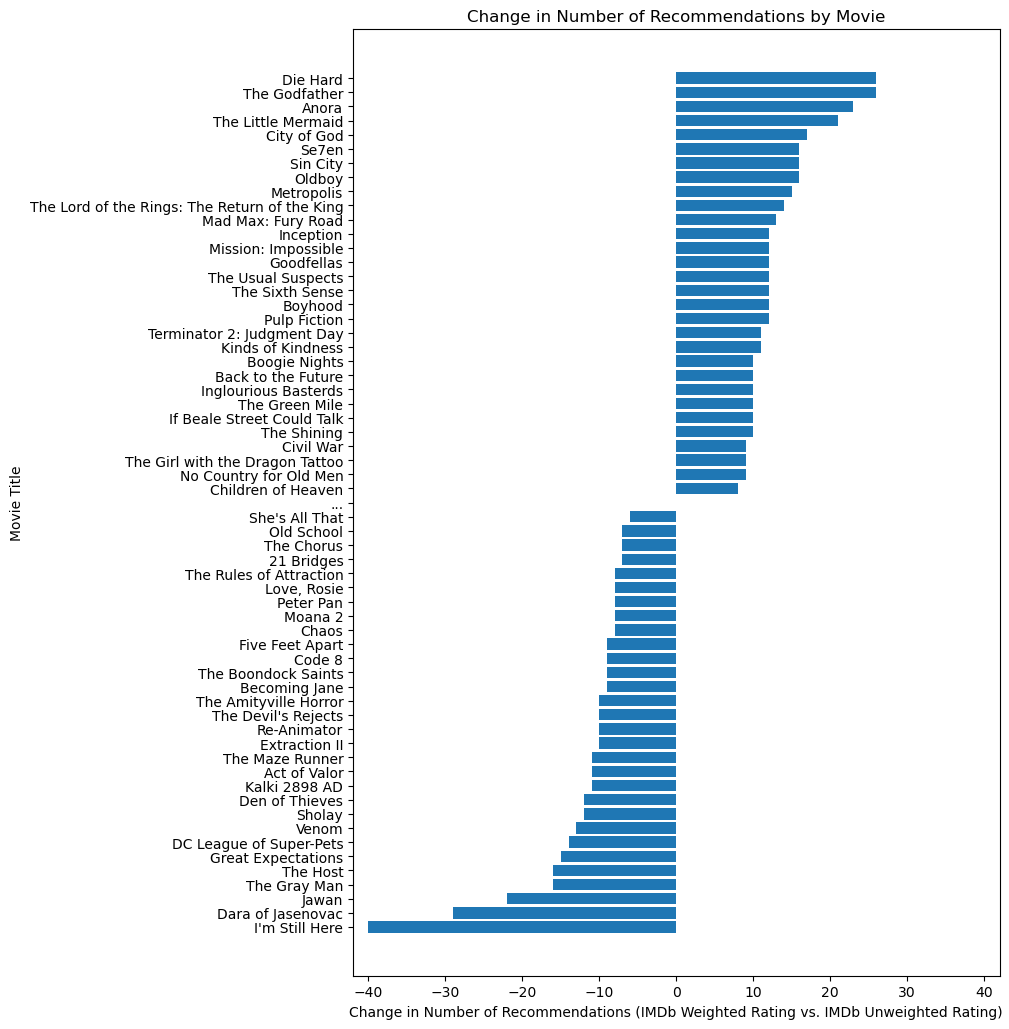

In [124]:
df_to_plot = diff_recommendation_data.sort_values('num_recommendations_diff', ascending=True)

df_to_plot = pd.concat((
    df_to_plot.head(30),
    pd.DataFrame([{'title': '...', 'num_recommendations_diff': 0}]),
    df_to_plot.tail(30)
))

plt.figure(figsize=(10, 10))
plt.barh(df_to_plot['title'], df_to_plot['num_recommendations_diff'])
max_abs_value = df_to_plot['num_recommendations_diff'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.ylabel('Movie Title')
plt.xlabel('Change in Number of Recommendations (IMDb Weighted Rating vs. IMDb Unweighted Rating)')
plt.title('Change in Number of Recommendations by Movie')
plt.show()

In [125]:
title = 'Die Hard'
movies.loc[naive(movies[movies['title'] == title].iloc[0], movies[movies['title'] != title], 'weighted_rating').sort_values(ascending=False).head(10).index]['title']

1925                    Die Hard 2
2216     Die Hard with a Vengeance
47                  Den of Thieves
1546          Escape from New York
809                       Commando
1606      Clear and Present Danger
1907    Rambo: First Blood Part II
455                   The Gray Man
1874                 Patriot Games
3394                  Broken Arrow
Name: title, dtype: object

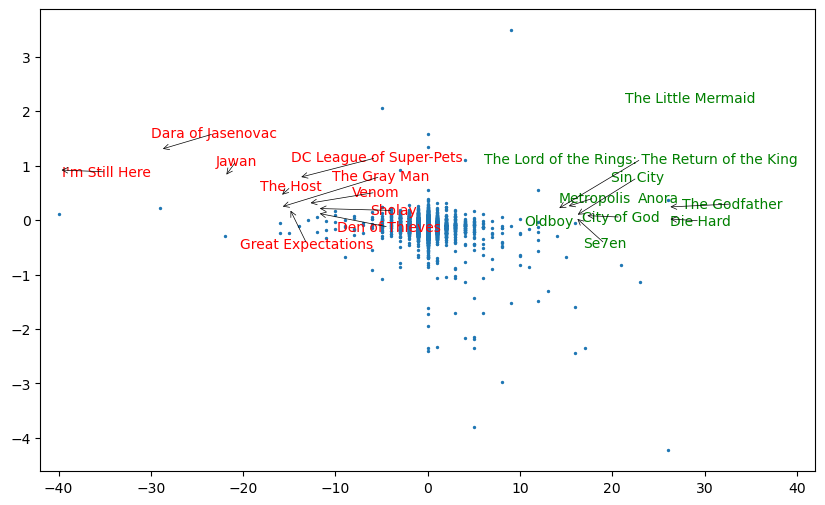

In [126]:
df_to_plot = diff_recommendation_data.sort_values('num_recommendations_diff', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    df_to_plot['num_recommendations_diff'],
    movies.loc[diff_recommendation_data.index]['rating_diff'],
    s=2
)
max_abs_value = df_to_plot['num_recommendations_diff'].abs().max() * 1.05
plt.xlim(-max_abs_value, max_abs_value)

texts = []
for i, movie in enumerate(df_to_plot.tail(10).itertuples()):
    texts.append(ax.text(movie.num_recommendations_diff, abs(movies.loc[movie.Index]['rating_diff']), movie.title, color='green'))

for i, movie in enumerate(df_to_plot.head(10).itertuples()):
    texts.append(ax.text(movie.num_recommendations_diff, abs(movies.loc[movie.Index]['rating_diff']), movie.title, color='red'))


adjust_text(texts, autoalign='xy', 
            expand_points=(1.2, 1.2), 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

plt.show()